<a href="https://colab.research.google.com/github/SihaoCheng/scattering_transform/blob/master/ST_image_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
# import packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# import ST module
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import ST

# set default saving directory
save_dir = 'drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


# Define function of image synthesis

In [15]:
def image_synthesis(image, J, L, num_pixel,
                    learnable_param_list = [(100, 1e-3)],
                    savedir = '',
                    device='cpu',
                    coef = 'ST',
                    random_seed = 987,
                    low_bound = -0.010):

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    image = image[:num_pixel, :num_pixel]
    image_torch = torch.from_numpy(image).type(torch.FloatTensor) + 5
    if device=='gpu':
        image_torch = image_torch.cuda()
    
    target_bi = bispectrum_calculator.forward(image_torch)
    target_ST = ST_calculator.forward(image_torch[None,:,:], J, L)[0][0]
    target_ST = target_ST[target_ST!=0].log()
    target_PS, _ = ST.get_power_spectrum(image_torch, 20, device)
    target_PS = target_PS.log()

#-------------------------------------------------------------------------------
    # define mock image
    class model_image(torch.nn.Module):
        def __init__(self):
            super(model_image, self).__init__()

            # initialize with GRF of same PS as target image
            image_to_train = torch.from_numpy(
                ST.get_random_data(image, num_pixel, num_pixel, "image").reshape(1,-1)*1
            ).type(torch.FloatTensor) + 5 + 0.000
            if device=='gpu':
                image_to_train = image_to_train.cuda()
            self.param = torch.nn.Parameter( image_to_train )
#-------------------------------------------------------------------------------
    model_fit = model_image()

    # define learnable
    for learnable_group in range(len(learnable_param_list)):
        num_step = learnable_param_list[learnable_group][0]
        learning_rate = learnable_param_list[learnable_group][1]
        
        # optimizer = torch.optim.Adam(model_fit.parameters(), lr=learning_rate)
#         optimizer = torch.optim.SGD(model_fit.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adamax(model_fit.parameters(), lr=learning_rate)

        # optimize
        for i in range(int(num_step)):
            # loss: power spectrum
            PS, _ = ST.get_power_spectrum(model_fit.param.reshape(num_pixel,num_pixel), 20, device)
            PS = PS.log()
            loss_PS = ((target_PS - PS)**2).sum()
            # loss: L1
            target_L1 = (image_torch-5).abs().mean() 
            loss_L1 = (
                ((model_fit.param-5).abs().mean() - target_L1) / target_L1 
            )**2*1e6
            # loss: mean
            loss_mean = (
                model_fit.param.reshape(1,num_pixel,num_pixel).mean() - 
                image_torch.mean()
            )**2*1e7
            # loss: bound
            loss_bound = torch.exp(
                (5 + low_bound - model_fit.param.reshape(1,num_pixel,num_pixel))/0.003
            ).mean()

            if coef=='bi':
                bi = bispectrum_calculator.forward(
                    model_fit.param.reshape(num_pixel,num_pixel)
                )
                loss_bi = ((target_bi - bi)**2).sum()
                loss = loss_bi + loss_bound + loss_mean + loss_L1

            if coef=='bi+P':
                bi = bispectrum_calculator.forward(
                    model_fit.param.reshape(num_pixel,num_pixel)
                )
                loss_bi = ((target_bi - bi)**2).sum()
                loss = loss_bi + loss_bound + loss_mean + loss_L1 + loss_PS
                
            elif coef=='ST':
                ST_coef = ST_calculator.forward(
                    model_fit.param.reshape(1,num_pixel,num_pixel), J, L,
                  )[0][0]
                ST_coef = ST_coef[ST_coef!=0].log()
                loss_ST = ((target_ST - ST_coef)**2).sum()*1000
                loss = loss_ST + loss_bound + loss_mean + loss_L1
            else:
                loss = loss_bound + loss_mean + loss_L1
                
            if i%100== 0:
                # save map
                # np.save(savedir + 'synthesis_results_step=' + str(i) + '.npy', 
                #         model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5)
                # np.save(savedir +'synthesis_results_final.npy', 
                #         model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5)
                print(i)
                print('loss: ',loss)
                print('loss_mean: ',loss_mean)
                print('loss_bound: ',loss_bound)
                print('loss_L1: ',loss_L1)
                if coef=='bi' or coef=='bi+P':
                    print('loss_bi: ',loss_bi)
                if coef=='bi+P':
                    print('loss_PS: ',loss_PS)
                if coef=='ST':
                    print('loss_ST: ',loss_ST)

            optimizer.zero_grad();
            loss.backward();
            optimizer.step();

    return model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5

# Load data & Create calculators

# Load target image

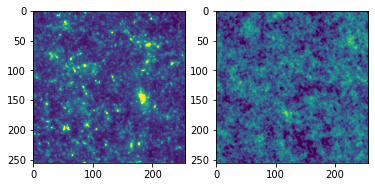

In [3]:
# load target image

save_dir = 'drive/My Drive/Colab Notebooks/'

M = 256
N = M
image = np.load('drive/My Drive/Colab Notebooks/H51_9.npy')[:M,:N]
plt.subplot(121)
plt.imshow(image, vmin=-0.03, vmax=0.1)
plt.subplot(122)
np.random.seed(989)
plt.imshow(ST.get_random_data(image, M, N, mode='image'), vmin=-0.04, vmax=0.1)
plt.show()

# CPU / GPU

In [4]:
device = 'gpu' # 'cpu'

# Generate wavelet filter bank

In [5]:
J = 7
L = 8
filters_set = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_morlet(
    if_save=False, save_dir=None, precision='single'
)

# Create an ST calculator

In [6]:
ST_calculator = ST.ST_2D(filters_set, J, L, device=device)
image_torch = torch.from_numpy(image)[None,:,:]
if device=='gpu':
  image_torch = image_torch.cuda()

torch.set_num_threads(2) 
start = time.time()
S = ST_calculator.forward(image_torch, J, L)[0]
print('% .4f s' % (time.time() - start))

 0.0139 s


# Create a bispectrum calculator 

In [7]:
bin_edges = np.linspace(150/(360/3.5), M/2*1.4, 7) # in unit of pixel in Fourier space

bispectrum_calculator = ST.Bispectrum_Calculator(bin_edges, M, N, device=device)
image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

torch.set_num_threads(1) 
start = time.time()
B = bispectrum_calculator.forward(image_torch)
print('% .4f s' % (time.time() - start))

 0.0033 s


In [8]:
B[:10]

tensor([1222.5204,   91.3163,   26.3665,   15.9117,   22.9145,    6.0671,
           2.4983,    4.0757,    1.5234,    5.9161], device='cuda:0')

# Test the power spectrum function

In [9]:
bins = 20
device = 'gpu'

image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

ST.get_power_spectrum(image_torch, bins, device)

(tensor([53.3838, 93.8556, 41.9548, 83.6829, 44.1747, 64.8740, 50.9655, 45.3023,
         31.6566, 24.7657, 19.0566, 15.1125, 11.2181,  8.2779,  5.8608,  3.8872,
          2.4603,  1.4145,  0.7755,  0.4221], device='cuda:0'),
 tensor([  0.0000,   1.0000,   1.3140,   1.7266,   2.2688,   2.9812,   3.9173,
           5.1473,   6.7636,   8.8874,  11.6781,  15.3450,  20.1634,  26.4948,
          34.8143,  45.7461,  60.1106,  78.9856, 103.7874, 136.3771, 179.2000],
        device='cuda:0'))

# Run synthesis & Show result

0
loss:  tensor(7998074.5000, device='cuda:0', grad_fn=<AddBackward0>)
loss_mean:  tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
loss_bound:  tensor(7924621.5000, device='cuda:0', grad_fn=<MeanBackward0>)
loss_L1:  tensor(28746.8242, device='cuda:0', grad_fn=<MulBackward0>)
loss_ST:  tensor(44706.1172, device='cuda:0', grad_fn=<MulBackward0>)
100
loss:  tensor(11541.8066, device='cuda:0', grad_fn=<AddBackward0>)
loss_mean:  tensor(2.4830, device='cuda:0', grad_fn=<MulBackward0>)
loss_bound:  tensor(11305.2275, device='cuda:0', grad_fn=<MeanBackward0>)
loss_L1:  tensor(0.0245, device='cuda:0', grad_fn=<MulBackward0>)
loss_ST:  tensor(234.0708, device='cuda:0', grad_fn=<MulBackward0>)
0
loss:  tensor(8918.6631, device='cuda:0', grad_fn=<AddBackward0>)
loss_mean:  tensor(2.3935, device='cuda:0', grad_fn=<MulBackward0>)
loss_bound:  tensor(8804.1211, device='cuda:0', grad_fn=<MeanBackward0>)
loss_L1:  tensor(0.0021, device='cuda:0', grad_fn=<MulBackward0>)
loss_ST:  tensor(112.1468, 

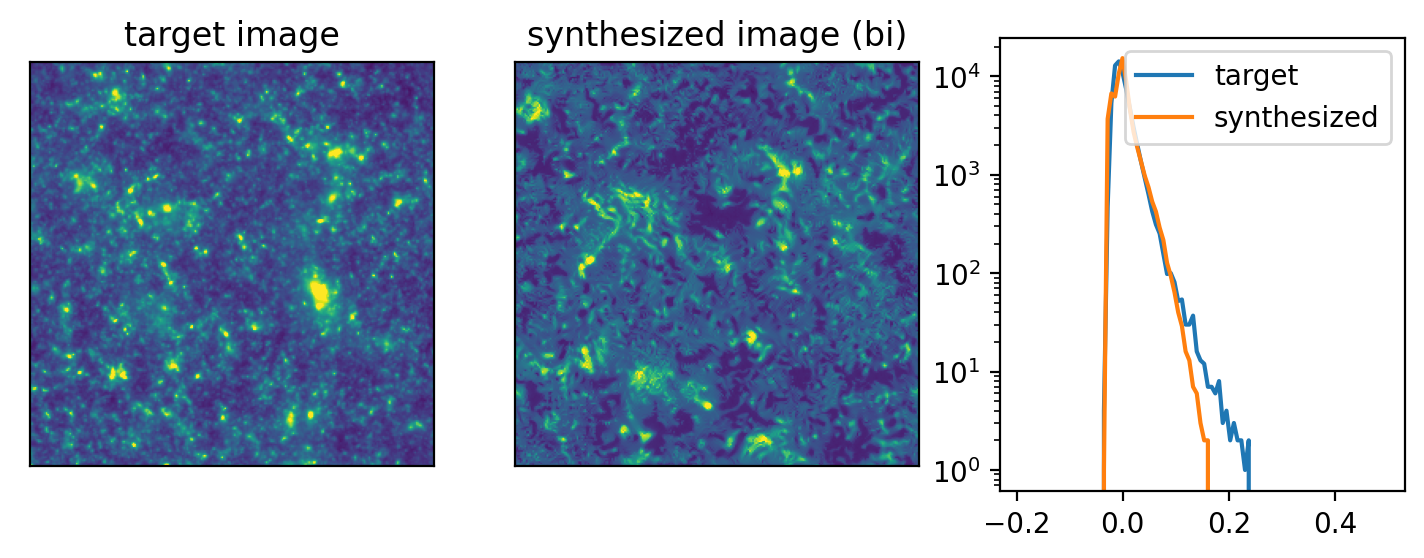

0.02026283 0.019999439


In [16]:
# synthesis

coef = 'ST'#'bi+P'
device = 'gpu'

for random_seed in [987]:
    synthesised_image = image_synthesis(
        image, J=J, L=L, num_pixel=M,
        learnable_param_list = [
            (100*2, 5e-3), (100*2, 1e-3), (100*1, 1e-3),
            (100*1, 5e-4), (100*1, 2e-4), (100*1, 1e-4),
        ],
        savedir = save_dir,
        device = device,
        coef = coef,
        random_seed = random_seed,
        low_bound = -0.015,#-0.010,
    )
    # np.save(save_dir +'synthesis_results_final.npy', synthesised_image)
    
    synthesised_image = synthesised_image[0]
    plt.figure(figsize=(12,3),dpi=200)
    plt.subplot(141)
    plt.imshow(image, vmin=-0.04, vmax=0.10, )
    plt.title('target image')
    plt.xticks([]); plt.yticks([])

    plt.subplot(142)
    plt.imshow(synthesised_image, 
               vmin=-0.04, vmax=0.10, )
    plt.title('synthesized image (bi)')
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(143)
    y, x = np.histogram(image,  100, (-0.2,0.5))
    plt.plot((x[1:]+x[:-1])/2, y, label='target')
    y, x = np.histogram(synthesised_image,
                        100, (-0.2,0.5))
    plt.plot((x[1:]+x[:-1])/2, y, label='synthesized')
    plt.legend()
    plt.yscale('log')
    plt.show()
    print(image.std(),  synthesised_image.std())